# Makemore MLP

Name generation using MLP and multi-dimensional embeddings to enable use of a context window size > 1.

In the previous implementation of makemore, only the current character is used to predict the next character. This produces poor results, however to take into account additional previous characters we cannot use a lookup table as we did before because the table size grows exponentially. This is referred to as the "Curse of Dimensionality". Instead here we will use a multi-layer neural network (or multi-layer perceptron, aka MLP) which can handle more input context with as little as a few thousand parameters. We can scale up the MLP internal dimensions (also known as "Hyperparameters") to get better results.

The MLP is based on the paper Bengio et al https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf 

MLP diagram from the paper:

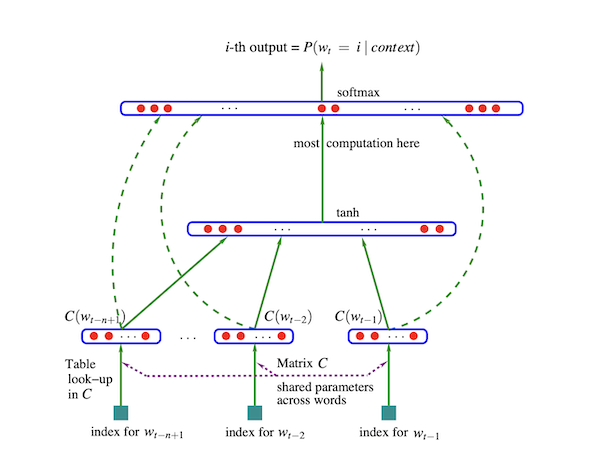

The embedding of characters helps to improve the model because the training tunes the embeddings such that tokens that have similar contribution or semantics will end up at similar locations in the embedding vector space. The smoothing properties of the model mean that similar input vectors produce a similar output probability distribution. Smoothing could be improved through regularization (https://en.wikipedia.org/wiki/Regularization_(mathematics)), though that is not part of this implementation.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Enable MPS

Enable GPU for MacOS

In [235]:
mps_device = torch.device("mps")
print(f"{mps_device=}")
print(f"{mps_device.index=}")
torch.set_default_device(mps_device)

mps_device=device(type='mps')
mps_device.index=None


## Data Set

The data set is constructed from `names.txt` which contains around 32K names from census data. This is formed into inputs formed from each sequence of 3 characters (X) and output labels (Y) based on the character that appears next in the data. Here below we sample the first 5 words to produce the first 32 inputs/labels.

In [302]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [303]:
len(words)

32033

In [304]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(f"{stoi=}\n")
print(f"{itos=}")

stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [305]:
# build the (training) dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [306]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]], device='mps:0')

In [307]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0],
       device='mps:0')

In [308]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [309]:
X[13,2]

tensor(1, device='mps:0')

## Character Embedding

Create the lookup table for character embeddeding. Here we will use a 2-dimensional embedding for each of the 27 characters

In [310]:
C = torch.randn((27, 2))
C.dtype

torch.float32

In [311]:
C[:10]

tensor([[ 0.1529,  1.1201],
        [-1.2754,  1.2613],
        [ 0.7560,  1.0705],
        [-0.4355,  0.4776],
        [ 0.9190,  0.3226],
        [ 0.0224,  1.8703],
        [-0.9476,  0.2352],
        [-1.8289,  1.8174],
        [-0.5272,  0.5678],
        [-1.1062,  1.5681]], device='mps:0')

In [312]:
# Example of looking up the vector for 'e'
C[stoi['e']]

tensor([0.0224, 1.8703], device='mps:0')

In [313]:
# Aside: Another option for lookup is to multiply C by the one-hot encoding of the character index.
# This works because since the OH encoding is all zeros except 1 for the index, the multiplication has
# the same effect of picking out just the row of the embedding vector at the requested index
# This means that the embedding lookup can be viewed as just another layer of the NN.
print(f"{stoi['e']=}")
print(f"{F.one_hot(torch.tensor(stoi['e']), num_classes=27)=}")
# Note we need to cast the one-hot vector to float in order to multiply by C
print(f"{F.one_hot(torch.tensor(stoi['e']), 27).float() @ C=}")

stoi['e']=5
F.one_hot(torch.tensor(stoi['e']), num_classes=27)=tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], device='mps:0')
F.one_hot(torch.tensor(stoi['e']), 27).float() @ C=tensor([0.0224, 1.8703], device='mps:0')


In [314]:
# With tensor-based lookup we can use multiple indices
C[torch.tensor([5,6,7])]

tensor([[ 0.0224,  1.8703],
        [-0.9476,  0.2352],
        [-1.8289,  1.8174]], device='mps:0')

In [315]:
# We can also use multi-dimensional tensor indices
C[X[:3]]

tensor([[[0.1529, 1.1201],
         [0.1529, 1.1201],
         [0.1529, 1.1201]],

        [[0.1529, 1.1201],
         [0.1529, 1.1201],
         [0.0224, 1.8703]],

        [[0.1529, 1.1201],
         [0.0224, 1.8703],
         [1.7133, 0.6014]]], device='mps:0')

So notice that `X[i]` is giving the 3 char indexes for the given input `i`, and `C[X[i]]` gives the 3x2 tensor for input `i`.

In [316]:
X[8]

tensor([15, 12,  9], device='mps:0')

In [317]:
C[X[8]]

tensor([[ 0.3746,  1.4332],
        [ 0.5003,  0.5942],
        [-1.1062,  1.5681]], device='mps:0')

In [318]:
# The output above has the shape of the index tensor plus the dimensions of the lookup table (2)
# Here we have 32 inputs each with 3 (block_size) values, and 2 dimensions to represent the embedding
C[X].shape

torch.Size([32, 3, 2])

## Building the MLP

Below we will go step by step to build the MLP with random parameters and evaluate the loss

Input layer, using the embeddings in C (note C functions as another parameter that will be tuned by autograd)

In [319]:
C = torch.randn((27, 2))

As mentioned above, `C[X]` are the embeddings corresponding to all inputs `X`

In [320]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

For the hidden layer we will use 100 parameters (the value 100 is a hyperparameter). W1 shape is (6,100) due to 3 input chars each with 2-dimensional embedding

In [321]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

The hidden layer (h) output uses tanh(). The emb.view() function is an efficient way to ensure the correct tensor shape.

The problem is that we have `[32,3,2]` but we need `[32,6]`, so we need to flatten out the index 1 and 2 dimensions of the embedding input.

In [322]:
# One possibility is to concatenate the 2D tensors at each input index by slicing at each of the 3 value for each input
# ie concatenate over dimension 1 of X
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)[:3]

tensor([[ 0.9854, -0.7527,  0.9854, -0.7527,  0.9854, -0.7527],
        [ 0.9854, -0.7527,  0.9854, -0.7527,  0.4427, -0.5097],
        [ 0.9854, -0.7527,  0.4427, -0.5097,  0.6070, -1.8776]],
       device='mps:0')

In [323]:
# Unfortunately the above is hard-coded to block_size
# Luckily, torch.unbind() will do the same thing without hard-coding
torch.cat(torch.unbind(emb, 1), 1)[:3]

tensor([[ 0.9854, -0.7527,  0.9854, -0.7527,  0.9854, -0.7527],
        [ 0.9854, -0.7527,  0.9854, -0.7527,  0.4427, -0.5097],
        [ 0.9854, -0.7527,  0.4427, -0.5097,  0.6070, -1.8776]],
       device='mps:0')

There is an even better option using the tensor `view()` method. See https://blog.ezyang.com/2019/05/pytorch-internals/ for some details on how this works very efficiently because it is presenting a tensor as a different shape but without copying the data.

In [324]:
emb.view(32, 6)[:3]

tensor([[ 0.9854, -0.7527,  0.9854, -0.7527,  0.9854, -0.7527],
        [ 0.9854, -0.7527,  0.9854, -0.7527,  0.4427, -0.5097],
        [ 0.9854, -0.7527,  0.4427, -0.5097,  0.6070, -1.8776]],
       device='mps:0')

Instead of hard-coding 32 which is the number of inputs, we can just give -1

This allows us to express our hidden layer as follows:

In [325]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [326]:
h

tensor([[-0.9581,  0.9263,  0.1869,  ...,  0.5917, -0.0981,  0.9574],
        [-0.9255,  0.5292,  0.2480,  ...,  0.4861, -0.3127,  0.9846],
        [ 0.1396,  0.8557, -0.4911,  ...,  0.4099, -0.4217,  0.9911],
        ...,
        [-0.3089, -0.7382, -0.4040,  ..., -0.8153, -0.7337,  0.9640],
        [-0.9448,  0.9560, -0.9249,  ..., -0.8887,  0.2406, -0.5689],
        [ 0.4604,  0.9511, -0.9766,  ..., -0.9000,  0.9178, -0.8005]],
       device='mps:0')

Note that `b1` needs to be broadcasted to all the results in `emb @ W1`. This will work because of broadcasting rules since the dimensions (100) line up properly. See https://docs.pytorch.org/docs/stable/notes/broadcasting.html

In [327]:
print(f"{b1.shape=}")
print(f"{(emb.view(-1, 6) @ W1).shape=}")

# emb @ W1: 32, 100
#       b1:     100
# broadcast will cast b as 1,100 for the addition

b1.shape=torch.Size([100])
(emb.view(-1, 6) @ W1).shape=torch.Size([32, 100])


In [328]:
h.shape

torch.Size([32, 100])

The output is 27 logits which can be normalized to represent a probability distribution

In [329]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [330]:
logits = h @ W2 + b2

In [331]:
logits.shape

torch.Size([32, 27])

As before, exponentiate logits to get a count, then normalize to probability (softmax function)

In [345]:
counts = logits.exp()
print(f"{counts.shape=}")
prob = counts / counts.sum(1, keepdim=True)
print(f"{prob.shape=}")

counts.shape=torch.Size([32, 27])
prob.shape=torch.Size([32, 27])


In [353]:
# Illustrating the difference betweek keepdim=True and default which is keepdim=Fals
print(f"{counts[:5].sum(1).shape=}")

print(f"{counts[:5].sum(1, keepdim=True).shape=}")

counts[:5].sum(1).shape=torch.Size([5])
counts[:5].sum(1, keepdim=True).shape=torch.Size([5, 1])


Note all the probability distributions for all inputs X sum to 1.0

In [347]:
prob.sum(1, keepdim=True)[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0')

In [360]:
# Remember we can give a tensor to index another tensor
print(f"{torch.arange(32)=}")
print(f"{prob[torch.arange(32)].shape=}")
# We can thus pluck out the prob values assigned to the label values by indexing with the Y vector
print(f"{prob[torch.arange(32), Y].shape=}")

torch.arange(32)=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       device='mps:0')
prob[torch.arange(32)].shape=torch.Size([32, 27])
prob[torch.arange(32), Y].shape=torch.Size([32])


In [361]:
# Calculate mean negative log likelihood
loss = -prob[torch.arange(32), Y].log().mean()

Finally, here is the loss for the untrained MLP

In [363]:
loss

tensor(17.9551, device='mps:0')

NOTE: The loss calculation from logits and Y can be done more efficiently using `torch.nn.functional.cross_entropy()`, see https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy

The pytorch implementation here eliminates the intermediate tensor values and may do the entire computation in a "fused kernel", ie it can have a dedicated GPU operation that eliminates the sequential calculations.

One additional reason to use `cross_entropy()` is that there can be some floating point instabilities involved in using the above method and the `cross_entropy()` function takes care of this as well.

In [364]:
F.cross_entropy(logits, Y)

tensor(17.9551, device='mps:0')

## Data Set Partitioning

To avoid over-fitting the model, divide the data set into 3 partitions: Training, Dev/Validation, and Test

Example partition sizes 80%, 10%, 10%

In [383]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


# tr = trainig, dev = dev/validation, te = test
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Concise Model Definition

In [441]:
# Hyperparameters
# Starting definitions for a small mode (3481 parameters)
ctx_dim = block_size       # Context dimension (how many chars of context to input)
emb_dim = 2                # Embedding dimension (input lookup is 27 x emd_dim)
hdim = 100                 # Hidden layer dimension

In [455]:
# Hyperparameters
# Larger model (10281 parameters)
ctx_dim = block_size       # Context dimension (how many chars of context to input)
emb_dim = 2                # Embedding dimension (input lookup is 27 x emd_dim)
hdim = 300                 # Hidden layer dimension

In [459]:
# Hyperparameters
# Later model with higher dimensioned embedding (17697 parameters)
ctx_dim = block_size       # Context dimension (how many chars of context to input)
emb_dim = 10               # Embedding dimension (input lookup is 27 x emd_dim)
hdim = 300                 # Hidden layer dimension

In [457]:
# Parameters
# Note the hack below as generator needs to be on GPU if we are using it.
g = torch.Generator(device="mps").manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((ctx_dim * emb_dim, hdim), generator=g)
b1 = torch.randn(hdim, generator=g)
W2 = torch.randn((hdim, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Put all parameters in a list so we can iterate over them
parameters = [C, W1, b1, W2, b2]

In [458]:
sum(p.nelement() for p in parameters) # number of parameters in total

17697

## Learning Rate for Training

The learning rate is basically the amount we will multiply the gradient by at each parameter to reduce loss at each training step, ie
```python
  for p in parameters:
    p.data += -lr * p.grad
```

Here we can try some different learning rates to determine a good rate. We will use a range of exponents, ie 10^-3 .. 10^0

In [399]:
print(f"{10**-3=}")
print(f"{10**0=}")

10**-3=0.001
10**0=1


In [405]:
ratei = torch.arange(1000)
lre = torch.linspace(-3, 0, 1000)
lrs = (10**lre)

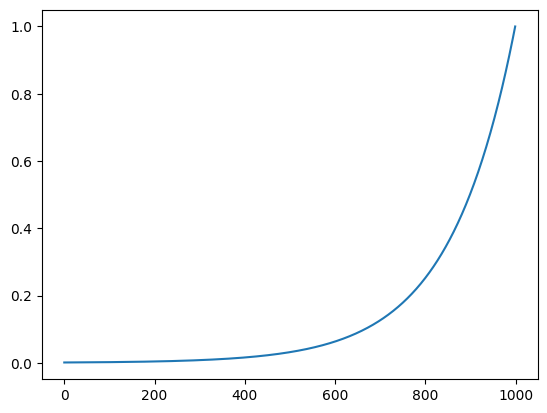

In [406]:
plt.plot(ratei.cpu(), lrs.cpu())

In [407]:
lossi = []
lri = []

In [408]:
for p in parameters:
  p.requires_grad = True

In [409]:
for i in range(1000):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, block_size, emb_dim)
    h = torch.tanh(emb.view(-1, ctx_dim * emb_dim) @ W1 + b1) # (32, hdim)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

7.034090995788574


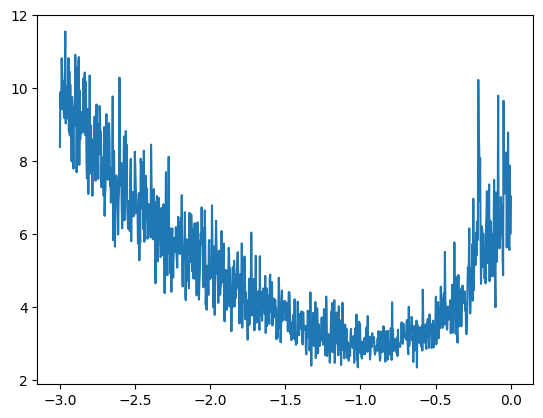

In [422]:
plt.plot(torch.tensor(lri).cpu(), torch.tensor(lossi).cpu())

Based on above, the lre (learning rate exponent) of -1.0 (ie lr = 0.1) gives the best loss improvement.

In the training below, after some number of steps we will decreate lr to 0.01 for finer adjustments. This is called learning rate decay.

## Training

Before starting, re-generate the model from the definition above.

In [460]:
for p in parameters:
  p.requires_grad = True

In [461]:
lossi = []
stepi = []

In [462]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, block_size, emb_dim)
  h = torch.tanh(emb.view(-1, ctx_dim * emb_dim) @ W1 + b1) # (32, hdim)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

Below we can plot the loss over the iterations

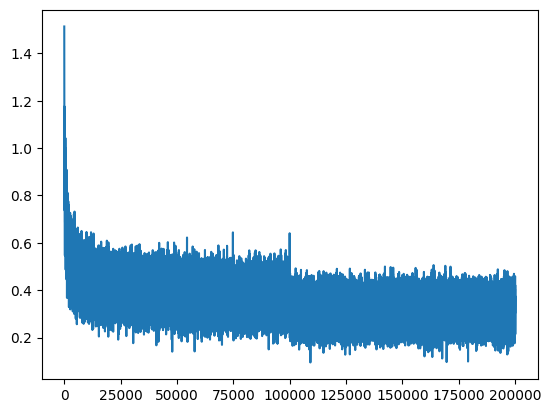

In [463]:
plt.plot(stepi, lossi)

In [464]:
# Calculate the loss over the training set
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, ctx_dim * emb_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1028, device='mps:0', grad_fn=<NllLossBackward0>)

In [465]:
# Calculate the loss over the dev set
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, ctx_dim * emb_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1683, device='mps:0', grad_fn=<NllLossBackward0>)

Below is a scatter plot of the embeddings. Note for example the clustering of the vowels. For this plot the emb_dim needs to be 2 but the other hyperparameters can be adjusted.

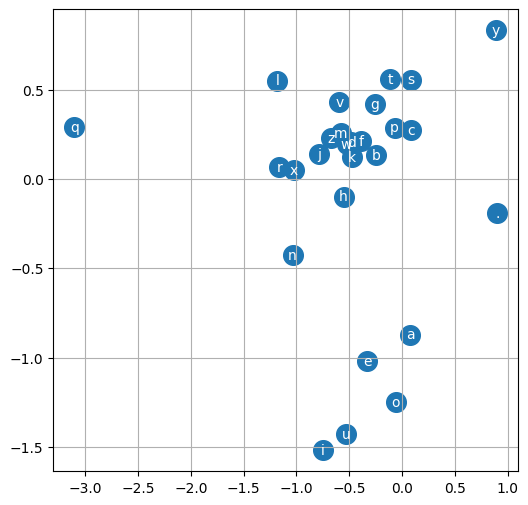

In [432]:
# for dimension 2 embedding we can visualize
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
if emb_dim == 2:
    plt.figure(figsize=(6,6))
    plt.scatter(C[:,0].cpu().data, C[:,1].cpu().data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    plt.grid('minor')

In [467]:
# Calculate the loss over the test set
# Note this is using the Larger model with higher embedding dimension
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, ctx_dim * emb_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1633, device='mps:0', grad_fn=<NllLossBackward0>)

## Sampling from the model

In [468]:
# sample from the model
g = torch.Generator(device="mps").manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

giaraj.
jorioneleaggn.
breylanico.
rosocie.
sie.
jeb.
xhae.
nellei.
rowin.
julity.
manevis.
kaccola.
kasianeem.
aratehes.
hose.
willyn.
loi.
shaiven.
iseemarant.
mika.


LOL it's still a bit like r/tragedeigh, but better than the previous single layer model.